In [3]:
# copyright: yueshi@usc.edu
import pandas as pd
import hashlib
import os
from utils import logger
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np


from sklearn.feature_selection import SelectFromModel
from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from utils import logger
# def lassoSelection(X,y,)


def lassoSelection(X_train, y_train, n):
    '''
    Lasso feature selection.  Select n features. 
    '''
    # lasso feature selection
    #print (X_train)
    clf = LassoCV(tol=0.01)
    sfm = SelectFromModel(clf, threshold=0)
    sfm.fit(X_train, y_train)
    X_transform = sfm.transform(X_train)
    n_features = X_transform.shape[1]

    # print(n_features)
    while n_features > n:
        sfm.threshold += 0.01
        X_transform = sfm.transform(X_train)
        n_features = X_transform.shape[1]
    features = [index for index, value in enumerate(
        sfm.get_support()) if value == True]
    logger.info("selected features are {}".format(features))
    return features


def specificity_score(y_true, y_predict):
    '''
    true_negative rate
    '''
    true_negative = len([index for index, pair in enumerate(
        zip(y_true, y_predict)) if pair[0] == pair[1] and pair[0] == 0])
    real_negative = len(y_true) - sum(y_true)
    return true_negative / real_negative


def model_fit_predict(X_train, X_test, y_train, y_test):

    np.random.seed(2018)
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.ensemble import ExtraTreesClassifier
    from sklearn.svm import SVC
    from sklearn.metrics import precision_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    models = {
        'LogisticRegression': LogisticRegression(),
        'ExtraTreesClassifier': ExtraTreesClassifier(),
        'RandomForestClassifier': RandomForestClassifier(),
        'AdaBoostClassifier': AdaBoostClassifier(),
        'GradientBoostingClassifier': GradientBoostingClassifier(),
        'SVC': SVC()
    }
    
    tuned_parameters = {
        'LogisticRegression': {'C': [1, 10]},
        'ExtraTreesClassifier': {'n_estimators': [16, 32]},
        'RandomForestClassifier': {'n_estimators': [16, 32]},
        'AdaBoostClassifier': {'n_estimators': [16, 32]},
        'GradientBoostingClassifier': {'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0]},
        'SVC': {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    }
    scores = {}
    for key in models:
        clf = GridSearchCV(
            models[key], tuned_parameters[key], scoring=None,  refit=True, cv=10)
        clf.fit(X_train, y_train)
        y_test_predict = clf.predict(X_test)
        precision = precision_score(y_test, y_test_predict, average='weighted')
        accuracy = accuracy_score(y_test, y_test_predict)
        f1 = f1_score(y_test, y_test_predict, average='weighted')
        recall = recall_score(y_test, y_test_predict, average='weighted')
        specificity = specificity_score(y_test, y_test_predict)
        scores[key] = [precision, accuracy, f1, recall, specificity]
    # print(scores)
    return scores


def draw(scores):
    '''
    draw scores.
    '''
    import matplotlib.pyplot as plt
    logger.info("scores are {}".format(scores))
    ax = plt.subplot(111)
    precisions = []
    accuracies = []
    f1_scores = []
    recalls = []
    categories = []
    specificities = []
    N = len(scores)
    ind = np.arange(N)  # set the x locations for the groups
    width = 0.1        # the width of the bars
    for key in scores:
        categories.append(key)
        precisions.append(scores[key][0])
        accuracies.append(scores[key][1])
        f1_scores.append(scores[key][2])
        recalls.append(scores[key][3])
        specificities.append(scores[key][4])

    precision_bar = ax.bar(ind, precisions, width=0.1,
                           color='b', align='center')
    accuracy_bar = ax.bar(ind+1*width, accuracies,
                          width=0.1, color='g', align='center')
    f1_bar = ax.bar(ind+2*width, f1_scores, width=0.1,
                    color='r', align='center')
    recall_bar = ax.bar(ind+3*width, recalls, width=0.1,
                        color='y', align='center')
    specificity_bar = ax.bar(ind+4*width, specificities,
                             width=0.1, color='purple', align='center')

    print(categories)
    ax.set_xticks(np.arange(N))
    ax.set_xticklabels(categories)
    ax.legend((precision_bar[0], accuracy_bar[0], f1_bar[0], recall_bar[0],
               specificity_bar[0]), ('precision', 'accuracy', 'f1', 'sensitivity', 'specificity'))
    ax.grid()
    plt.show()

In [4]:
# copyright: yueshi@usc.edu
import pandas as pd
import hashlib
import os
from utils import logger


def file_as_bytes(file):
    with file:
        return file.read()


def extractMatrix(dirname):
    '''
    return a dataframe of the miRNA matrix, each row is the miRNA counts for a file_id

    '''
    count = 0

    miRNA_data = []
    for idname in os.listdir(dirname):
        # list all the ids
        if idname.find("-") != -1:
            idpath = dirname + "/" + idname

            # all the files in each id directory
            for filename in os.listdir(idpath):
                # check the miRNA file
                if filename.find("-") != -1:

                    filepath = idpath + "/" + filename
                    df = pd.read_csv(filepath, sep="\t")
                    # columns = ["miRNA_ID", "read_count"]
                    if count == 0:
                        # get the miRNA_IDs
                        miRNA_IDs = df.miRNA_ID.values.tolist()

                    id_miRNA_read_counts = [idname] + \
                        df.read_count.values.tolist()
                    miRNA_data.append(id_miRNA_read_counts)

                    count += 1
                    # print (df)
    columns = ["file_id"] + miRNA_IDs
    df = pd.DataFrame(miRNA_data, columns=columns)
    return df


def extractLabel(inputfile):
    df = pd.read_csv(inputfile, sep="\t")
    columns = ['file_id', 'cases.0.case_id', 'cases.0.samples.0.sample_type']
    return df[columns]


def extractSite(inputfile):
    df = pd.read_csv(inputfile, sep="\t")
    return df[['id', 'primary_site']]


In [5]:
data_dir = "../"
# Input directory and label file. The directory that holds the data. Modify this when use.
dirname = data_dir + "live_miRNA"
label_file = data_dir + "files_meta.tsv"
case_file = data_dir + "cases_meta.tsv"

# output file
outputfile = data_dir + "miRNA_matrix_3.csv"

# extract data
matrix_df = extractMatrix(dirname)
label_df = extractLabel(label_file)
label_df.rename(columns={"cases.0.case_id":"id"}, inplace=True)
case_df = extractSite(case_file)
case_df.columns

# merge the two based on the file_id
result = pd.merge(matrix_df, label_df, on='file_id', how="left")
result = pd.merge(result, case_df, on='id', how="left")
result.to_csv(outputfile, index=False)

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2802: DtypeWarning: Columns (1,5,9,10,11,12,13,14,15,16,17,18,21,22,23,24,25,26,29,30,31,32,33,34,35,36,37,38,39,40,45,50,54,55,56,57,58,59,71,72,73,74,75,76,77,78,79,80,81,84,86,87,89,90,92,97,98,99,110,111,112,113,114,115,117,124,125,136,138,139,140,141,142,143,144,145,146,148,149,151,152,165,177,178,179,180,181,182,183,184,185,186,187,191,192,194,200,203,204,205,214,215,217,218,219,222,223,224,225,226,227,228,229,230,231,233,234,242,243,254,264,265,266,267,268,269,270,271,273,274,275,276,277,278,279,280,282,283,284,285,286,287,288,289,290) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
data_dir = "../"
data_file = data_dir + "miRNA_matrix_3.csv"
df_raw = pd.read_csv(data_file)
df_raw['label'] = df_raw['cases.0.samples.0.sample_type']
df_raw.loc[df_raw['cases.0.samples.0.sample_type'].str.contains("Cancer|Tumor"), 'label'] = df_raw['primary_site'] + ' Cancer'
df_raw.loc[df_raw['cases.0.samples.0.sample_type'].str.contains("Normal"), 'label'] = 'Normal'
df_label = df_raw['label'].value_counts()
df_raw = df_raw[df_raw['label'].isin(df_label[df_label > 100].index)]
print(df_raw['label'].value_counts())

Breast Cancer                                             1097
Kidney Cancer                                             1073
Bronchus and lung Cancer                                  1000
Normal                                                     691
Corpus uteri Cancer                                        550
Brain Cancer                                               532
Thyroid gland Cancer                                       507
Ovary Cancer                                               500
Prostate gland Cancer                                      498
Colon Cancer                                               458
Stomach Cancer                                             452
Bladder Cancer                                             417
Liver and intrahepatic bile ducts Cancer                   408
Metastatic                                                 380
Cervix uteri Cancer                                        307
Blood Cancer                                           

In [7]:
y_raw = df_raw['label']
from sklearn.preprocessing import LabelEncoder  
le = LabelEncoder()
le.fit(y_raw)
# print(len(le.classes_))
y_data = le.transform(y_raw)
# print(y_data)
df = df_raw.drop(['file_id', 'id', 'cases.0.samples.0.sample_type', 'primary_site', 'label'], axis=1)
X_data = df.values

In [8]:
# split the data to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.3, random_state=0)

# standardize the data.
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[2018-10-22 03:02:10,868 - GDC - INFO] selected features are [10, 240, 252, 285, 1461, 1848, 1860]
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision',

['LogisticRegression', 'ExtraTreesClassifier', 'RandomForestClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'SVC']


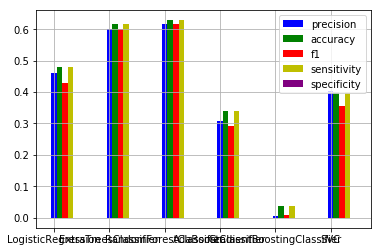

In [9]:
n = 7
feaures_columns = lassoSelection(X_train, y_train, n)
scores = model_fit_predict(
    X_train[:, feaures_columns], X_test[:, feaures_columns], y_train, y_test)
draw(scores)

In [10]:
# PCA 
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
feat_cols = df.columns
pca_result = pca.fit_transform(df[:].values)

print ('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.30419072 0.23384715 0.14848309 0.13555392]


C:\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


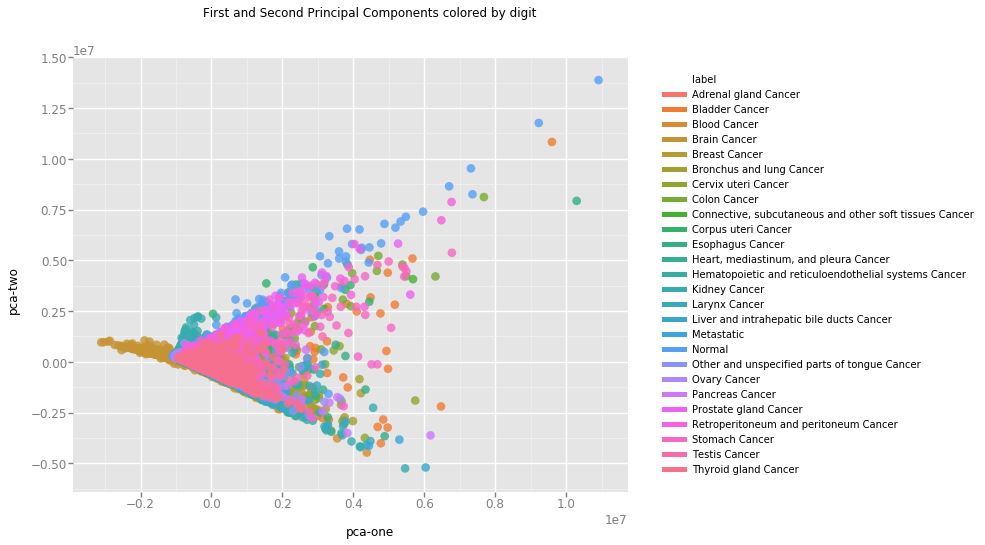

<ggplot: (-9223371904702205247)>

In [11]:
from ggplot import *

df_pca = df.loc[:, feat_cols].copy()
df_pca['pca-one'] = pca_result[:,0]
df_pca['pca-two'] = pca_result[:,1] 
df_pca['label'] = y_raw
chart = ggplot(df_pca, aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

In [12]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[:, feat_cols].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10628 samples in 1.394s...
[t-SNE] Computed neighbors for 10628 samples in 112.699s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10628
[t-SNE] Computed conditional probabilities for sample 2000 / 10628
[t-SNE] Computed conditional probabilities for sample 3000 / 10628
[t-SNE] Computed conditional probabilities for sample 4000 / 10628
[t-SNE] Computed conditional probabilities for sample 5000 / 10628
[t-SNE] Computed conditional probabilities for sample 6000 / 10628
[t-SNE] Computed conditional probabilities for sample 7000 / 10628
[t-SNE] Computed conditional probabilities for sample 8000 / 10628
[t-SNE] Computed conditional probabilities for sample 9000 / 10628
[t-SNE] Computed conditional probabilities for sample 10000 / 10628
[t-SNE] Computed conditional probabilities for sample 10628 / 10628
[t-SNE] Mean sigma: 78175.371262
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.474358
[t-S

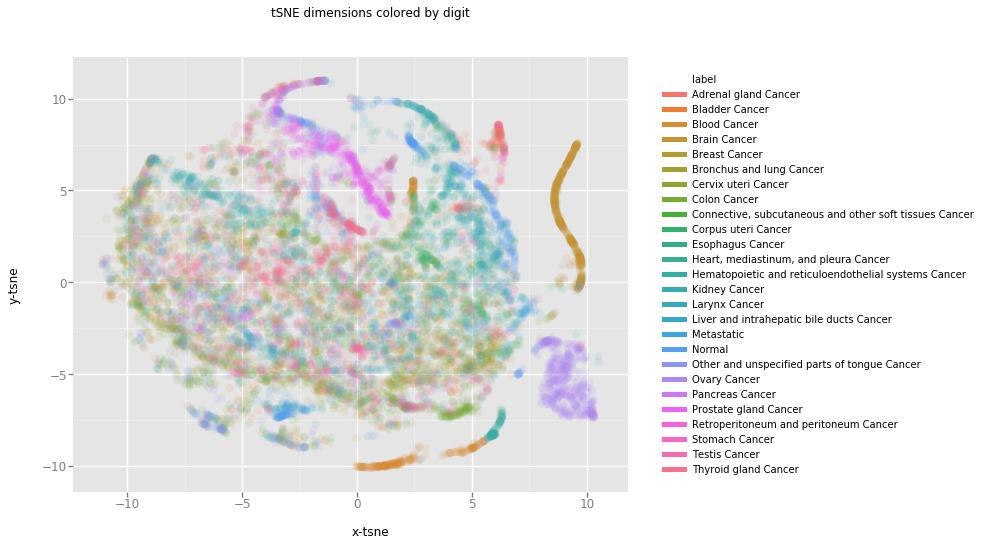

<ggplot: (132159064703)>

In [13]:
df_tsne = df.loc[:, feat_cols].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

df_tsne['label'] = y_raw

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

[2018-10-22 03:15:38,912 - GDC - INFO] scores are {'Naive Bayes': [0.6782085553049542, 0.7127626215114456, 0.6823605852361165, 0.7089579484343199, -0.0021030814715474414]}


['Naive Bayes']


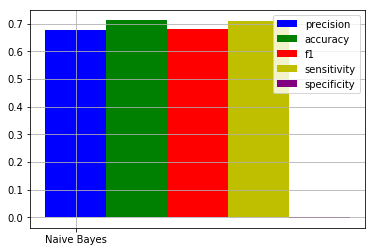

{'Naive Bayes': [0.6782085553049542, 0.7127626215114456, 0.6823605852361165, 0.7089579484343199, -0.0021030814715474414]}


In [14]:
# Naive Bayes
from sklearn.naive_bayes import BernoulliNB
# from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

nb_parameters = {'alpha': [0.5, 0.8, 1.0]}
clf_nb = GridSearchCV(BernoulliNB(), nb_parameters, scoring=None,  refit=True, cv=10)
clf_nb.fit(X_train, y_train)
y_test_predict = clf_nb.predict(X_test)
precision_nb = precision_score(y_test, y_test_predict, average='macro')
accuracy_nb = accuracy_score(y_test, y_test_predict)
f1_nb = f1_score(y_test, y_test_predict, average='macro')
recall_nb = recall_score(y_test, y_test_predict, average='macro')
specificity_nb = specificity_score(y_test, y_test_predict)
score_nb = {}
score_nb['Naive Bayes'] = [precision_nb, accuracy_nb, f1_nb, recall_nb, specificity_nb]
draw(score_nb)
print(score_nb)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

n_classes = len(le.classes_)

y_score = clf_nb.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test.shape

(3189,)

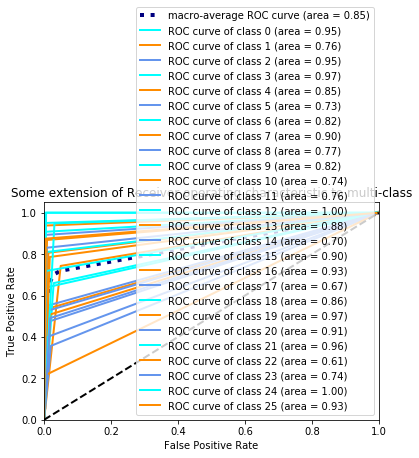

In [16]:
all_y_test_i = np.array([])
all_y_predict_proba = np.array([])

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_test_predict))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
lw = 2

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()